In [2]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from utils.plot_fairness import plot_fpr_fnr

%matplotlib inline 

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


#### Read in fairness data

In [84]:
# read in fairness data for all problems 
fairness_data = {}
for time_period in ["six-month", "two-year"]:
    for problem in ['drug', 'felony', 'general', 'misdemeanor', 'property', 'violent']:
        problem_path = "broward/logs/fairness_results/" + time_period + "/" + problem
        # walk through the problem folder for the corresponding fairness results for all models
#         for _, _, files in os.walk(problem_path):
        dircontents = os.listdir()
        onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        for filename in onlyfiles:
            model_name = filename.split("_")[0]
            time_period_formatted = time_period.replace("-", "_")
            fairness_data["-".join((time_period_formatted, problem, model_name))] = pd.read_csv(problem_path + "/" + filename)

fairness_data.keys()

dict_keys(['six_month-drug-cart', 'six_month-drug-corel', 'six_month-drug-ebm', 'six_month-drug-riskslim', 'six_month-drug-stumps', 'six_month-felony-cart', 'six_month-felony-corel', 'six_month-felony-ebm', 'six_month-felony-riskslim', 'six_month-felony-stumps', 'six_month-general-cart', 'six_month-general-corel', 'six_month-general-ebm', 'six_month-general-riskslim', 'six_month-general-stumps', 'six_month-misdemeanor-cart', 'six_month-misdemeanor-corel', 'six_month-misdemeanor-ebm', 'six_month-misdemeanor-riskslim', 'six_month-misdemeanor-stumps', 'six_month-property-cart', 'six_month-property-corel', 'six_month-property-ebm', 'six_month-property-riskslim', 'six_month-property-stumps', 'six_month-violent-cart', 'six_month-violent-corel', 'six_month-violent-ebm', 'six_month-violent-riskslim', 'six_month-violent-stumps', 'two_year-drug-cart', 'two_year-drug-corel', 'two_year-drug-ebm', 'two_year-drug-riskslim', 'two_year-drug-stumps', 'two_year-felony-cart', 'two_year-felony-corel', 'tw

#### Read in base rates and model performance info 

In [85]:
# read in AUCs for all predictions problems 
six_month_interpretable_performance = pd.read_csv("broward/logs/models/FL-six-month-interpretable-summary.csv")
two_year_interpretable_performance = pd.read_csv("broward/logs/models/FL-two-year-interpretable-summary.csv")

# clean up performance dataframe
six_month_interpretable_performance["time_period"] = "six_month"
two_year_interpretable_performance["time_period"] = "two_year"

interpretable_performance = pd.concat([six_month_interpretable_performance, 
                                       two_year_interpretable_performance],
                                     axis=0).rename({"Unnamed: 0": "prediction_problem",
                                                     "Lasso Stumps": "stumps"}, axis=1)

interpretable_performance.columns = [col.lower() for col in interpretable_performance.columns]
interpretable_performance.columns

Index(['prediction_problem', 'cart', 'ebm', 'stumps', 'riskslim', 'corel',
       'performance range', 'arnold psa', 'time_period'],
      dtype='object')

In [86]:
# read in base rates for all problems 
base_rates_decoder = {"recid_two_year": "general two_year",
                      "recid_six_month": "general six_month",
                      "recid_drug2": "drug two_year",
                      "recid_property2": "property two_year",
                      "recid_M2": "misdemeanor two_year",
                      "recid_F2": "felony two_year",
                      "recid_violent2": "violent two_year",
                      "recid_drug6": "drug six_month",
                      "recid_property6": "property six_month",
                      "recid_M6": "misdemeanor six_month",
                      "recid_F6": "felony six_month",
                      "recid_violent6": "violent six_month"
                     }
base_rates = pd.read_csv("broward/logs/base_rate/FL-base-rate.csv")
base_rates[["prediction_problem", "time_period"]] = (base_rates.label
                                                     .replace(to_replace = base_rates_decoder)
                                                     .str.split(expand=True))
del base_rates["label"]
base_rates

,base_rate,prediction_problem,time_period
0,0.455,general,two_year
1,0.218,general,six_month
2,0.093,drug,two_year
3,0.090,property,two_year
4,0.272,misdemeanor,two_year
5,0.176,felony,two_year
6,0.210,violent,two_year
7,0.040,drug,six_month
8,0.050,property,six_month
9,0.125,misdemeanor,six_month


#### Equalized Odds Visualization 

In [87]:
# weighted average of the FPR and FNR for each attribute over all folds 

def summarize_equalized_odds(dfs_dict: dict) -> pd.DataFrame:
    """
    dfs: dictionary where the key is the "<problem_name>_<model_name>", value is the corresponding pandas df
    """
    eq_odds_summaries = {}
    
    # loop over each problem and model
    for df_name, df in dfs_dict.items():
        equalized_odds_data = df[["Attribute", "Attribute Value", "FPR", "FNR", "Individuals Evaluated On", "fold_num"]]

        # TODO: Figure out where all the NaNs come from
        equalized_odds_data = equalized_odds_data.fillna(0)

        FPR = equalized_odds_data.groupby(["Attribute", "Attribute Value"]).apply(lambda x: np.average(x["FPR"], weights=x["Individuals Evaluated On"]))
        FNR = equalized_odds_data.groupby(["Attribute", "Attribute Value"]).apply(lambda x: np.average(x["FNR"], weights=x["Individuals Evaluated On"]))
        # TODO: compute the weighted standard deviation 

        summary = (pd.concat((FPR, FNR), axis = 1)
                   .reset_index()
                   .rename({0: "FPR", 
                            1: "FNR"},
                            axis = 1))
        
        eq_odds_summaries[df_name] = summary
    return eq_odds_summaries

eq_odds_summaries = summarize_equalized_odds(fairness_data)
eq_odds_summaries.keys()

dict_keys(['six_month-drug-cart', 'six_month-drug-corel', 'six_month-drug-ebm', 'six_month-drug-riskslim', 'six_month-drug-stumps', 'six_month-felony-cart', 'six_month-felony-corel', 'six_month-felony-ebm', 'six_month-felony-riskslim', 'six_month-felony-stumps', 'six_month-general-cart', 'six_month-general-corel', 'six_month-general-ebm', 'six_month-general-riskslim', 'six_month-general-stumps', 'six_month-misdemeanor-cart', 'six_month-misdemeanor-corel', 'six_month-misdemeanor-ebm', 'six_month-misdemeanor-riskslim', 'six_month-misdemeanor-stumps', 'six_month-property-cart', 'six_month-property-corel', 'six_month-property-ebm', 'six_month-property-riskslim', 'six_month-property-stumps', 'six_month-violent-cart', 'six_month-violent-corel', 'six_month-violent-ebm', 'six_month-violent-riskslim', 'six_month-violent-stumps', 'two_year-drug-cart', 'two_year-drug-corel', 'two_year-drug-ebm', 'two_year-drug-riskslim', 'two_year-drug-stumps', 'two_year-felony-cart', 'two_year-felony-corel', 'tw

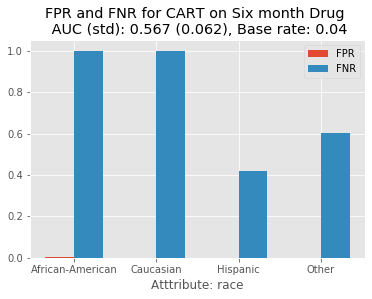

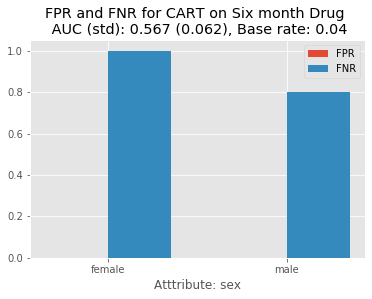

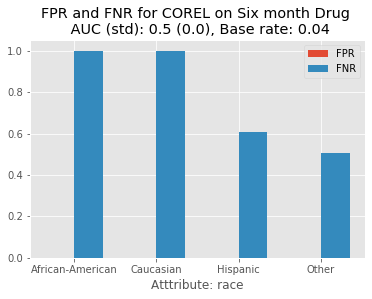

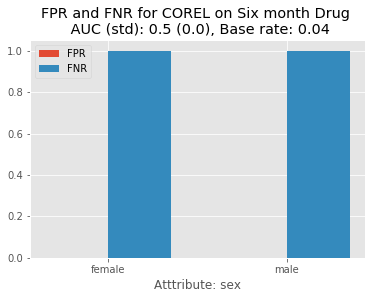

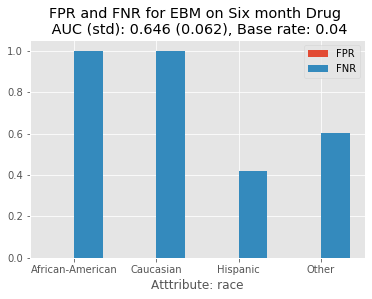

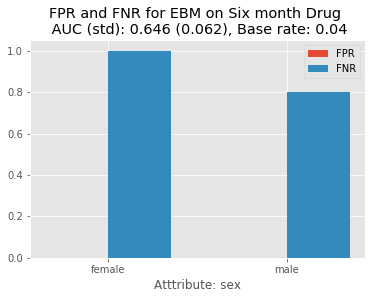

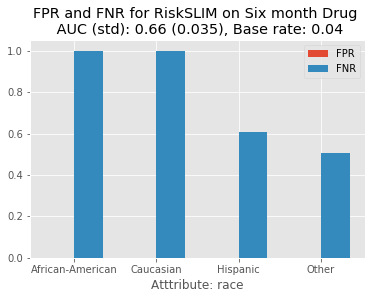

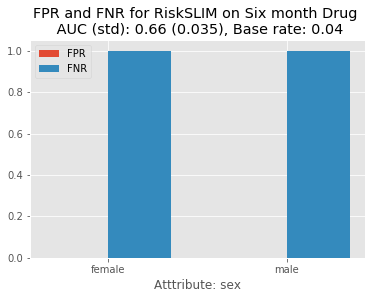

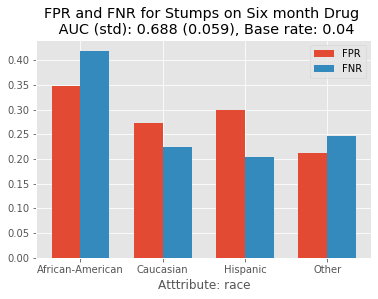

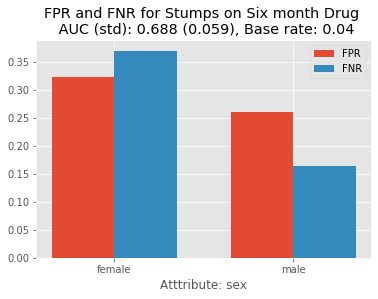

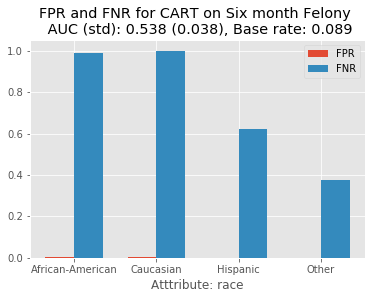

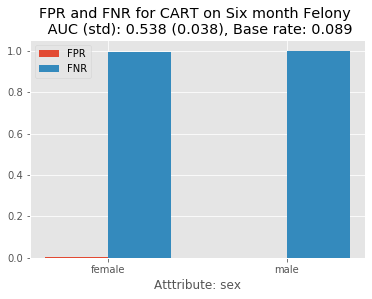

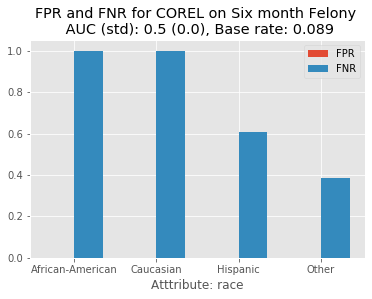

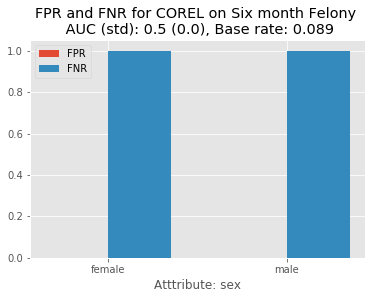

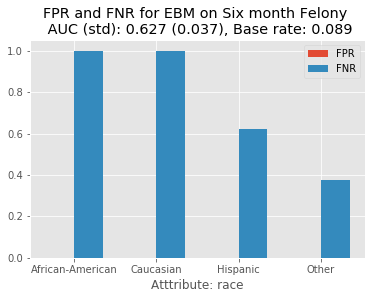

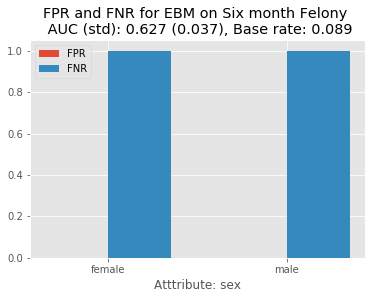

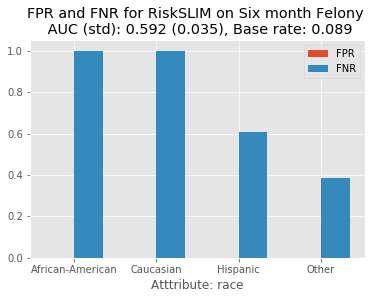

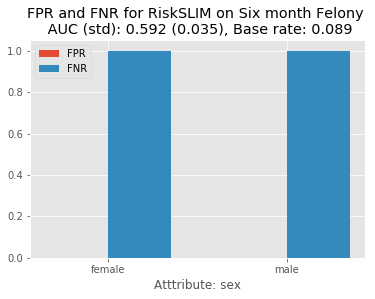

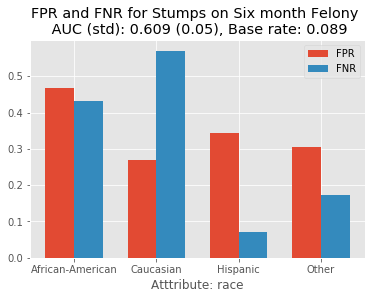

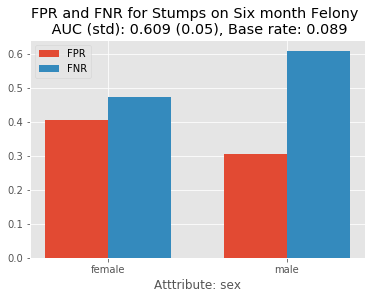

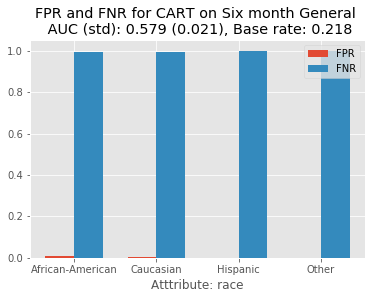

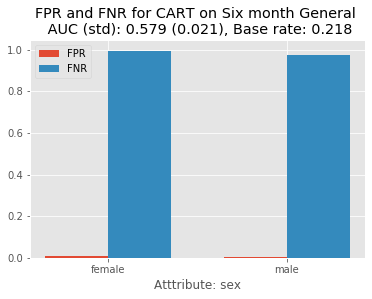

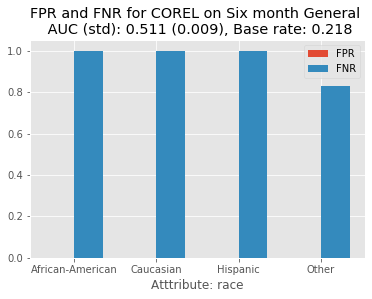

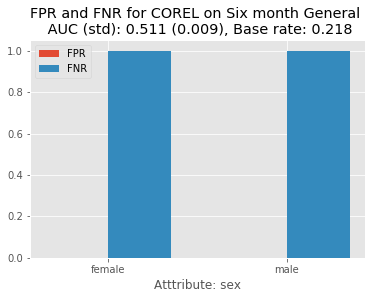

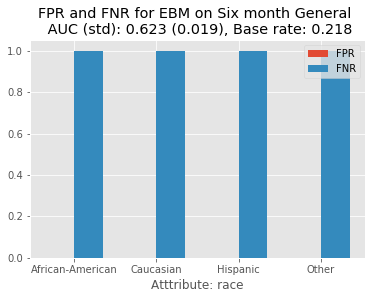

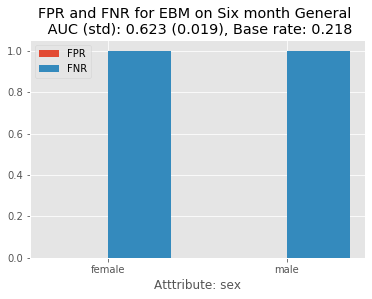

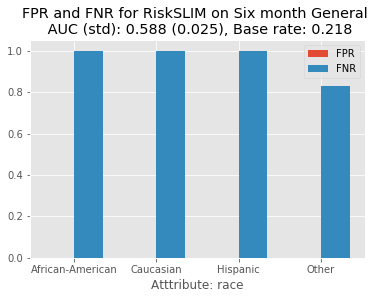

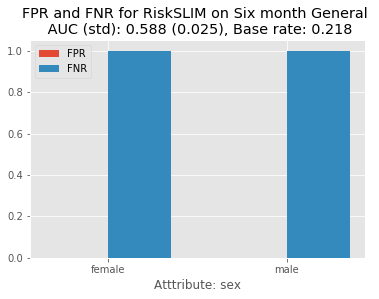

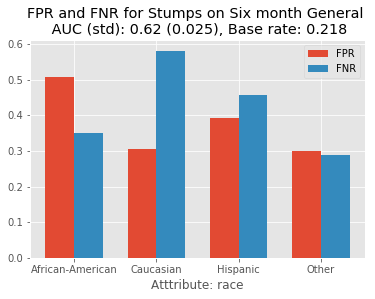

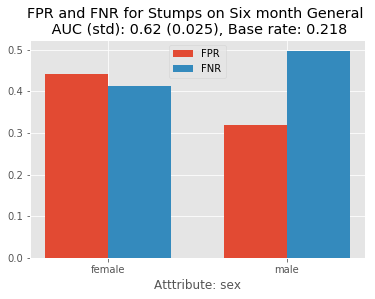

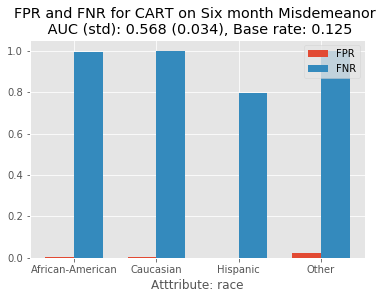

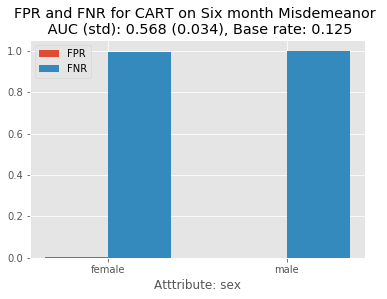

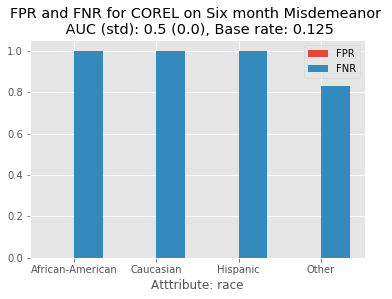

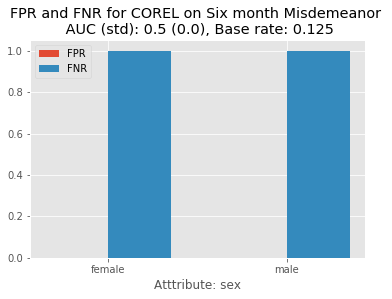

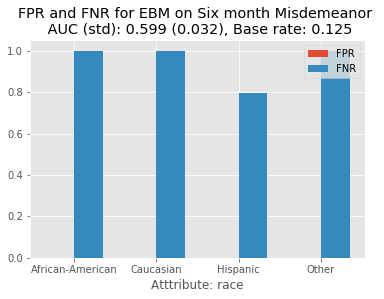

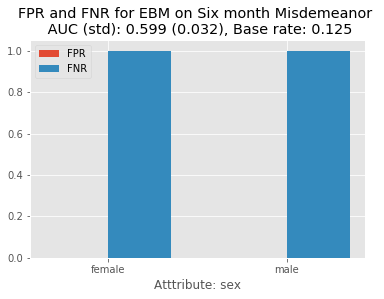

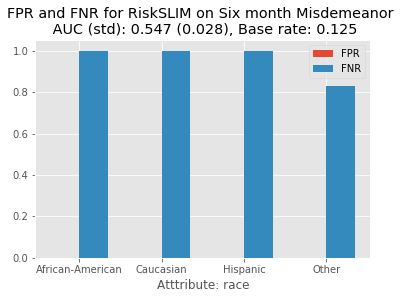

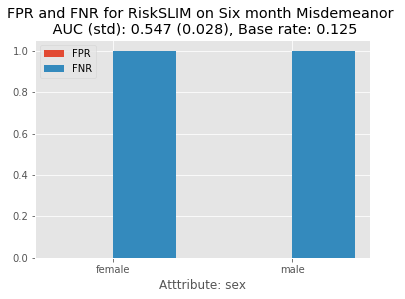

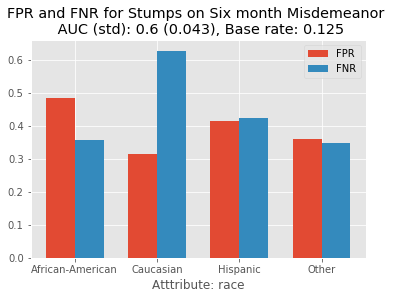

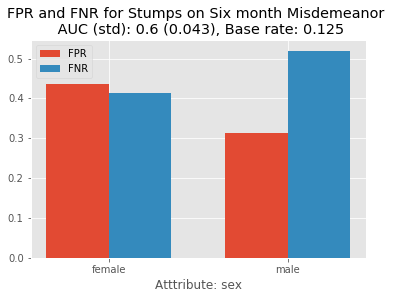

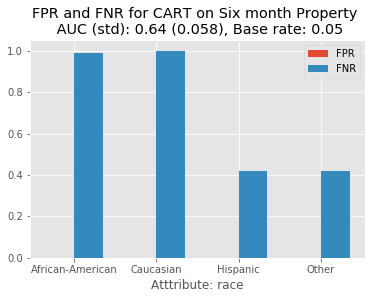

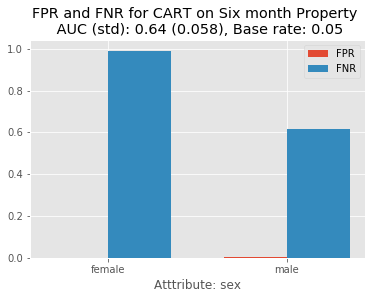

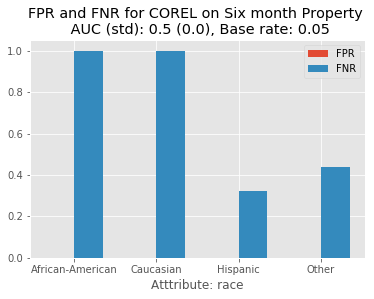

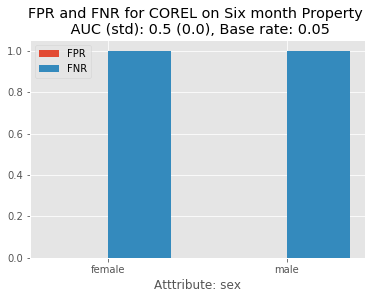

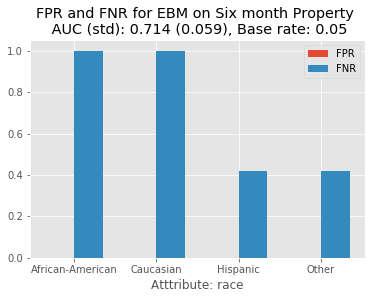

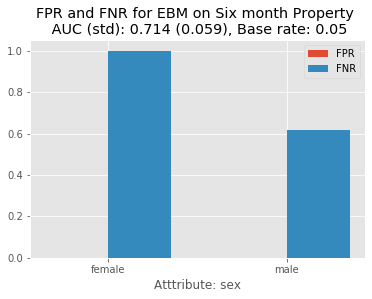

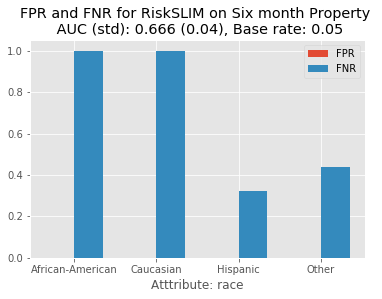

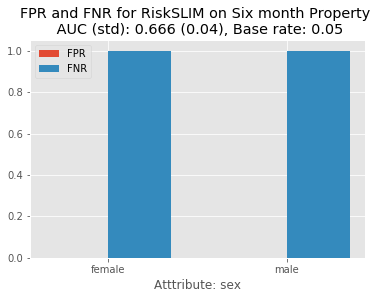

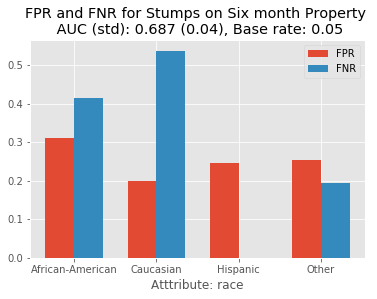

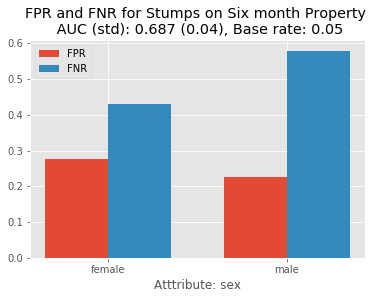

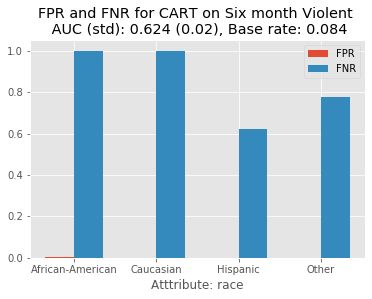

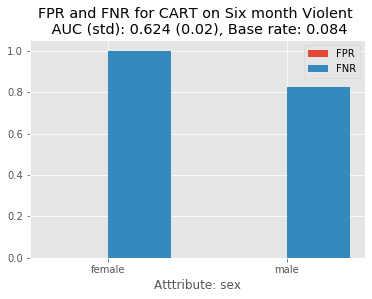

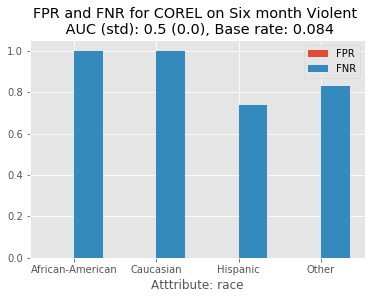

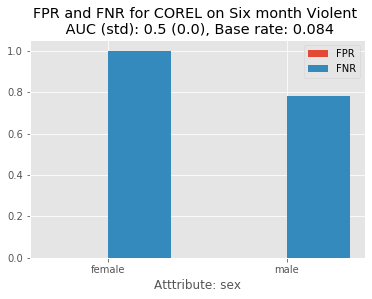

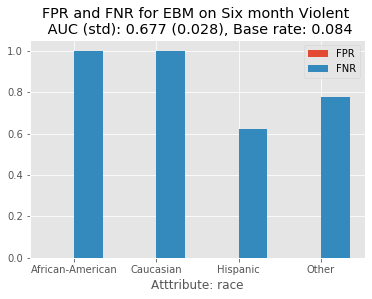

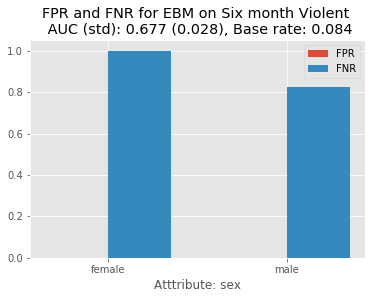

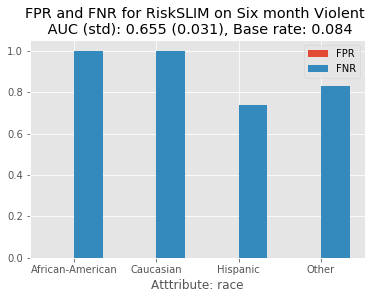

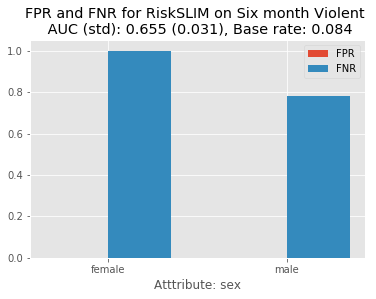

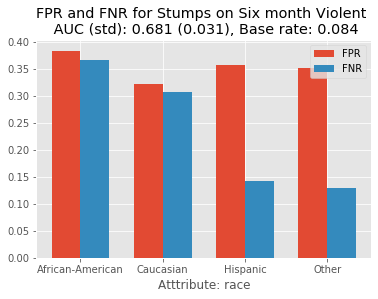

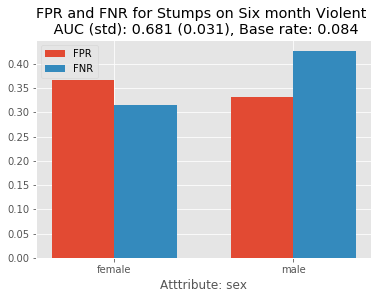

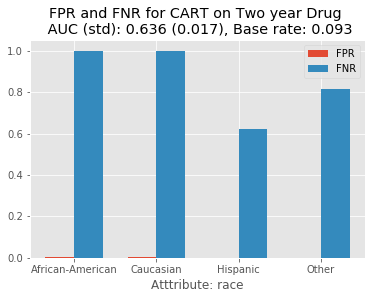

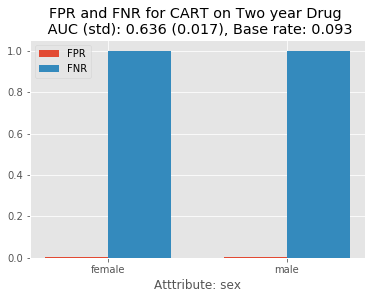

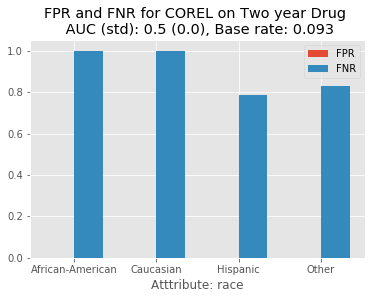

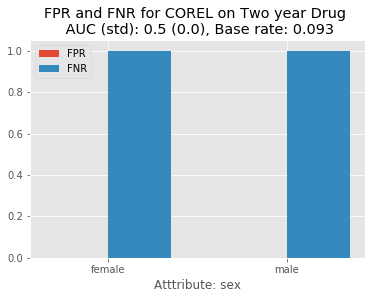

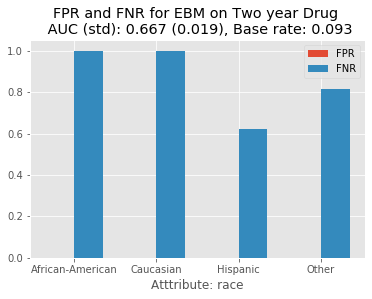

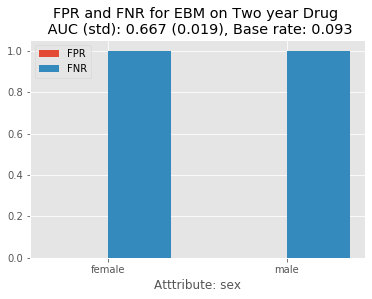

In [ ]:
root_save_path = "broward/logs/fairness_results/problem_model_specific_visualizations/"

for summary_name, summary in eq_odds_summaries.items():
    time_period, problem_name, model_name = summary_name.split("-")
    
    # get auc and std dev
    query = (interpretable_performance["prediction_problem"] == problem_name.capitalize()) & (interpretable_performance["time_period"] == time_period)
    model_performance = interpretable_performance[query][model_name].iloc[0]
    
    # get base rates 
    query = (base_rates["prediction_problem"] == problem_name) & (base_rates["time_period"] == time_period)
    base_rate = base_rates[query]["base_rate"].iloc[0].round(3)
    
    if model_name == "cart" or model_name == "ebm":
        model_name = model_name.upper()
    elif model_name == "riskslim":
        model_name = "RiskSLIM"
    elif model_name == "stumps": 
        model_name = model_name.capitalize()
    elif model_name == "corel": 
        model_name = "COREL"
    
    time_period_formatted = time_period.replace("_", " ").capitalize()
    plot_fpr_fnr(summary, 
                 problem_name = f"{time_period_formatted} {problem_name.capitalize()}", 
                 base_rate = base_rate,
                 model_name = model_name,
                 model_performance = model_performance, 
                 save_path= root_save_path + time_period + "/" + problem_name + "/" + model_name + "_equalized_odds.pdf")